In [1]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [2]:
import sys
import copy

DRIVE_PATH = '/gdrive/My Drive/Colab Notebooks/IoT_Inverting Gradients'

sys.path.append(DRIVE_PATH)

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from PIL import Image
from torchvision.utils import save_image

# Choose variants here:

In [4]:
arch = 'ConvNet64'
num_images = 8
trained_model = False

## System setup:

In [5]:
# Step 1: clone repo
!git clone https://github.com/JonasGeiping/invertinggradients.git

# Step 2: add to Python path
import sys
sys.path.append('/content/invertinggradients')

# Step 3: install dependencies
!pip install torch torchvision tqdm matplotlib

fatal: destination path 'invertinggradients' already exists and is not an empty directory.


In [6]:
import inversefed
setup = inversefed.utils.system_startup()
defs = inversefed.training_strategy('conservative')

loss_fn, trainloader, validloader =  inversefed.construct_dataloaders('CIFAR10', defs)

model, _ = inversefed.construct_model(arch, num_classes=10, num_channels=3)
model.to(**setup)
if trained_model:
    epochs = 120
    file = f'{arch}_{epochs}.pth'
    try:
        model.load_state_dict(torch.load(f'models/{file}'))
    except FileNotFoundError:
        inversefed.train(model, loss_fn, trainloader, validloader, defs, setup=setup)
        torch.save(model.state_dict(), f'models/{file}')
model.eval();

Currently evaluating -------------------------------:
Tuesday, 18. November 2025 08:21AM
CPUs: 1, GPUs: 1 on 4831c7a48e29.
GPU : Tesla T4
Model initialized with random key 1797103988.


In [7]:
dm = torch.as_tensor(inversefed.consts.cifar10_mean, **setup)[:, None, None]
ds = torch.as_tensor(inversefed.consts.cifar10_std, **setup)[:, None, None]
def plot(tensor):
    tensor = tensor.clone().detach()
    tensor.mul_(ds).add_(dm).clamp_(0, 1)
    if tensor.shape[0] == 1:
        return plt.imshow(tensor[0].permute(1, 2, 0).cpu());
    else:
        fig, axes = plt.subplots(1, tensor.shape[0], figsize=(12, tensor.shape[0]*12))
        for i, im in enumerate(tensor):
            axes[i].imshow(im.permute(1, 2, 0).cpu());

# Reconstruct

### Build the input (ground-truth) gradient

In [8]:
if num_images == 1:
    ground_truth_image = torch.as_tensor(np.array(Image.open("auto.jpg").resize((32, 32), Image.BICUBIC)) / 255,
                                         **setup)
    ground_truth = ground_truth_image.permute(2, 0, 1).sub(dm).div(ds).unsqueeze(0).contiguous()
    labels = torch.as_tensor((1,), device=setup['device'])
else:
    ground_truth, labels = [], []
    idx = 25 # choosen randomly ... just whatever you want
    while len(labels) < num_images:
        img, label = validloader.dataset[idx]
        idx += 1
        labels.append(torch.as_tensor((label,), device=setup['device']))
        ground_truth.append(img.to(**setup))
    ground_truth = torch.stack(ground_truth)
    labels = torch.cat(labels)

['bird', 'deer', 'airplane', 'truck', 'frog', 'frog', 'dog', 'deer']


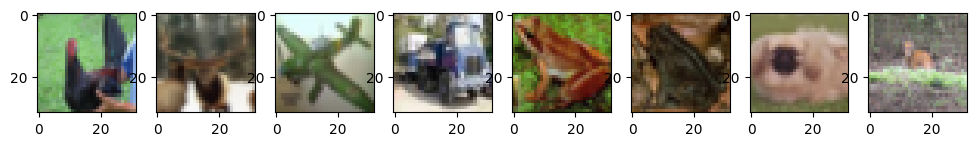

In [9]:
plot(ground_truth);
print([validloader.dataset.classes[l] for l in labels]);

# 클린

In [10]:
local_lr = 1e-4
local_steps = 5
use_updates = True

In [11]:
model.zero_grad()
target_loss, _, _ = loss_fn(model(ground_truth), labels)

# clean update
input_parameters = inversefed.reconstruction_algorithms.loss_steps(
    model, ground_truth, labels,
    lr=local_lr,
    local_steps=local_steps,
    use_updates=use_updates
)
input_parameters = [p.detach() for p in input_parameters]

In [12]:
# clean update 적용 후 loss 계산
model_clean = copy.deepcopy(model)
with torch.no_grad():
    for p, upd in zip(model_clean.parameters(), input_parameters):
        p -= local_lr * upd

loss_clean_after, _, _ = loss_fn(model_clean(ground_truth), labels)
delta_clean = (target_loss - loss_clean_after).item()

print("[CLEAN UPDATE]")
print("target_loss      :", target_loss.item())
print("loss_clean_after :", loss_clean_after.item())
print("delta_clean      :", delta_clean)
print()

[CLEAN UPDATE]
target_loss      : 2.298603057861328
loss_clean_after : 2.298603057861328
delta_clean      : 0.0



=== CLEAN RECONSTRUCTION ===
It: 0. Rec. loss: 0.0104.
It: 499. Rec. loss: 0.0033.
Choosing optimal result ...
Optimal result score: 0.0033
Total time: 148.85089206695557.


Text(0.5, 1.0, '[CLEAN] Rec. loss: 0.0033 | MSE: 0.3651 | PSNR: 16.65 | FMSE: 1.5916e-08 |')

<Figure size 640x480 with 0 Axes>

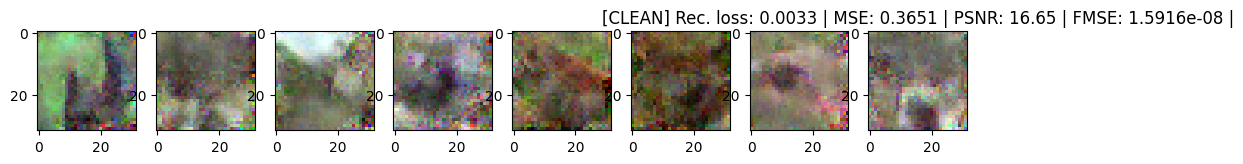

In [13]:
config = dict(
    signed=True,
    boxed=True,
    cost_fn='sim',
    indices='def',
    weights='equal',
    lr=1,
    optim='adam',
    restarts=1,
    max_iterations=500, ###d임시로 바꿈
    total_variation=1e-6,
    init='randn',
    filter='none',
    lr_decay=True,
    scoring_choice='loss'
)

print("=== CLEAN RECONSTRUCTION ===")
rec_machine = inversefed.FedAvgReconstructor(
    model, (dm, ds), local_steps, local_lr, config,
    use_updates=use_updates, num_images=num_images
)
output_clean, stats_clean = rec_machine.reconstruct(
    input_parameters, labels, img_shape=(3, 32, 32)
)

test_mse_clean = (output_clean.detach() - ground_truth).pow(2).mean()
feat_mse_clean = (model(output_clean.detach()) - model(ground_truth)).pow(2).mean()
psnr_clean = inversefed.metrics.psnr(output_clean, ground_truth, factor=1/ds)

plt.figure()
plot(output_clean)
plt.title(f"[CLEAN] Rec. loss: {stats_clean['opt']:2.4f} | MSE: {test_mse_clean:2.4f} "
          f"| PSNR: {psnr_clean:4.2f} | FMSE: {feat_mse_clean:2.4e} |")

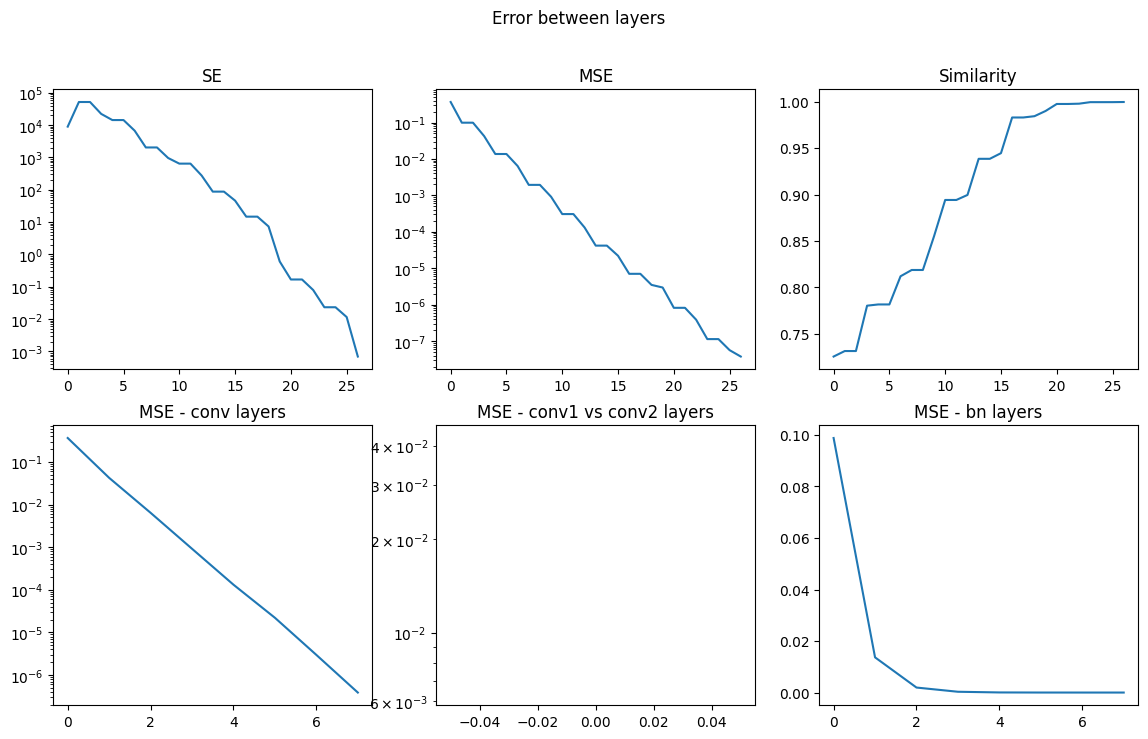

In [15]:
data = inversefed.metrics.activation_errors(model, output_clean, ground_truth)

fig, axes = plt.subplots(2, 3, sharey=False, figsize=(14,8))
axes[0, 0].semilogy(list(data['se'].values())[:-3])
axes[0, 0].set_title('SE')
axes[0, 1].semilogy(list(data['mse'].values())[:-3])
axes[0, 1].set_title('MSE')
axes[0, 2].plot(list(data['sim'].values())[:-3])
axes[0, 2].set_title('Similarity')

convs = [val for key, val in data['mse'].items() if 'conv' in key]
axes[1, 0].semilogy(convs)
axes[1, 0].set_title('MSE - conv layers')
convs = [val for key, val in data['mse'].items() if 'conv1' in key]
axes[1, 1].semilogy(convs)
convs = [val for key, val in data['mse'].items() if 'conv2' in key]
axes[1, 1].semilogy(convs)
axes[1, 1].set_title('MSE - conv1 vs conv2 layers')
bns = [val for key, val in data['mse'].items() if 'bn' in key]
axes[1, 2].plot(bns)
axes[1, 2].set_title('MSE - bn layers')
fig.suptitle('Error between layers');

# noisy 추가 버전

In [16]:
noise_scale = 0.01  # 원하는 크기로 설정
input_parameters_noisy = [
    upd + noise_scale * torch.randn_like(upd)
    for upd in input_parameters
]

In [17]:
# ============================================================
# NOISY UPDATE → LOSS 계산
# ============================================================
model_noisy = copy.deepcopy(model)
with torch.no_grad():
    for p, upd in zip(model_noisy.parameters(), input_parameters_noisy):
        p -= local_lr * upd

loss_noisy_after, _, _ = loss_fn(model_noisy(ground_truth), labels)
delta_noisy = (target_loss - loss_noisy_after).item()

print("[NOISY UPDATE]")
print("loss_noisy_after :", loss_noisy_after.item())
print("delta_noisy      :", delta_noisy)
print()

[NOISY UPDATE]
loss_noisy_after : 2.29860258102417
delta_noisy      : 4.76837158203125e-07



=== NOISY RECONSTRUCTION ===
It: 0. Rec. loss: 1.0002.
It: 499. Rec. loss: 0.9961.
Choosing optimal result ...
Optimal result score: 0.9961
Total time: 153.6428484916687.


Text(0.5, 1.0, '[NOISY] Rec. loss: 0.9961 | MSE: 3.2096 | PSNR: 6.98 | FMSE: 6.8209e-07 |')

<Figure size 640x480 with 0 Axes>

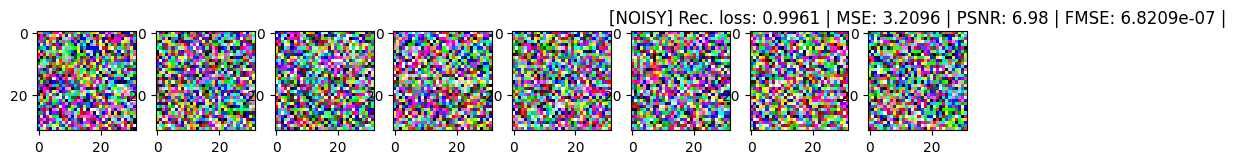

In [18]:
# ============================================================
# NOISY RECONSTRUCTION
# ============================================================
print("=== NOISY RECONSTRUCTION ===")
rec_machine = inversefed.FedAvgReconstructor(
    model, (dm, ds), local_steps, local_lr, config,
    use_updates=use_updates, num_images=num_images
)
output_noisy, stats_noisy = rec_machine.reconstruct(
    input_parameters_noisy, labels, img_shape=(3, 32, 32)
)

test_mse_noisy = (output_noisy.detach() - ground_truth).pow(2).mean()
feat_mse_noisy = (model(output_noisy.detach()) - model(ground_truth)).pow(2).mean()
psnr_noisy = inversefed.metrics.psnr(output_noisy, ground_truth, factor=1/ds)

plt.figure()
plot(output_noisy)
plt.title(f"[NOISY] Rec. loss: {stats_noisy['opt']:2.4f} | MSE: {test_mse_noisy:2.4f} "
          f"| PSNR: {psnr_noisy:4.2f} | FMSE: {feat_mse_noisy:2.4e} |")


In [19]:
# ============================================================
# UPDATE 효율 계산
# ============================================================
eps = 1e-12
utility = delta_noisy / (delta_clean + eps)

print("=== UPDATE UTILITY ===")
print(f"Clean loss reduction : {delta_clean:.8e}")
print(f"Noisy loss reduction : {delta_noisy:.8e}")
print(f"Utility (ratio)      : {utility:.6f}")
print("=============================================")

=== UPDATE UTILITY ===
Clean loss reduction : 0.00000000e+00
Noisy loss reduction : 4.76837158e-07
Utility (ratio)      : 476837.158203
